# Preprocessing

datasets and bipartite graphs for 2000-2005 and 2010-2015

## libraries

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## Load data

In [2]:

# 1. Load original CSVs
ratings = pd.read_csv("ratings.csv")   # userId, movieId, rating, timestamp
movies  = pd.read_csv("movies.csv")    # movieId, title, genres
tags    = pd.read_csv("tags.csv")      # userId, movieId, tag, timestamp
links   = pd.read_csv("links.csv")     # movieId, imdbId, tmdbId


# 2. Convert Unix timestamp (seconds since epoch) to datetime
#    If your timestamp is already datetime, you can skip this step.
ratings["datetime"] = pd.to_datetime(ratings["timestamp"], unit="s")
tags["datetime"]    = pd.to_datetime(tags["timestamp"], unit="s")


In [3]:
min_ts = ratings["timestamp"].min()
max_ts = ratings["timestamp"].max()

min_date = pd.to_datetime(min_ts, unit="s")
max_date = pd.to_datetime(max_ts, unit="s")

print("Oldest rating date:", min_date)
print("Newest rating date:", max_date)

Oldest rating date: 1996-03-29 18:36:55
Newest rating date: 2018-09-24 14:27:30


## Size of the datasets

In [4]:

def df_size_info(df, name):
    n_rows, n_cols = df.shape
    print(f"{name}:")
    print(f"  rows: {n_rows:,}")
    print(f"  columns: {n_cols}")

df_size_info(ratings, "ratings")
df_size_info(movies,  "movies")
df_size_info(tags,    "tags")
df_size_info(links,   "links")


ratings:
  rows: 100,836
  columns: 5
movies:
  rows: 9,742
  columns: 3
tags:
  rows: 3,683
  columns: 5
links:
  rows: 9,742
  columns: 3


## build edge list and bipartite graph for the periods

In [ ]:
def build_edge_list_for_period(
    ratings_df,
    movies_df,
    start_date,
    end_date,
    edge_csv_name=None
):
    """
    Build an enriched edge list (dataset) for ratings between
    start_date and end_date (inclusive).

    Parameters
    ----------
    ratings_df : DataFrame
        Original ratings DataFrame with a 'datetime' column.
    movies_df : DataFrame
        Movies DataFrame with movieId, title, genres.
    start_date : str or Timestamp
        Start of the period, e.g. '2000-01-01'.
    end_date : str or Timestamp
        End of the period, e.g. '2005-12-31'.
    edge_csv_name : str or None
        If provided, save the edge list to this CSV file.

    Returns
    -------
    edge_list : DataFrame
        Enriched edge list for the period (ready to be turned into a graph).
    """

    # 1. Filter ratings by date range (inclusive)
    mask = (ratings_df["datetime"] >= start_date) & (ratings_df["datetime"] <= end_date)
    ratings_period = ratings_df.loc[mask].copy()

    # 2. Merge ratings with movies to attach title and genres
    df = ratings_period.merge(movies_df, on="movieId", how="left")

    # 3. Build enriched edge list
    edge_list = df[["userId", "movieId", "rating", "title", "genres"]].copy()
    edge_list["weight"] = edge_list["rating"]

    # 4. Create explicit node IDs for bipartite graph
    edge_list["user_node"] = edge_list["userId"].apply(lambda x: f"u_{x}")
    edge_list["movie_node"] = edge_list["movieId"].apply(lambda x: f"m_{x}")

    # 5. Optionally save the edge list to CSV
    if edge_csv_name is not None:
        edge_list.to_csv(edge_csv_name, index=False)

    return edge_list


def build_bipartite_graph_from_edge_list(edge_list):
    """
    Build a bipartite graph (users <-> movies) from an enriched edge list.

    Parameters
    ----------
    edge_list : DataFrame
        DataFrame with columns:
        ['user_node', 'movie_node', 'weight', 'rating', 'movieId', 'title', 'genres'].

    Returns
    -------
    G : networkx.Graph
        Bipartite graph constructed from the edge list.
    """

    # 1. Build graph from edge list
    G = nx.from_pandas_edgelist(
        edge_list,
        source="user_node",
        target="movie_node",
        edge_attr=["weight", "rating"],
        create_using=nx.Graph()
    )

    # 2. Mark partitions (users vs movies)
    users = edge_list["user_node"].unique()
    movies_nodes = edge_list["movie_node"].unique()

    for u in users:
        G.nodes[u]["bipartite"] = "users"

    for m in movies_nodes:
        G.nodes[m]["bipartite"] = "movies"

    # 3. Add movie attributes to movie nodes (movieId, title, genres)
    movies_attrs = edge_list[["movie_node", "movieId", "title", "genres"]].drop_duplicates()
    for row in movies_attrs.itertuples(index=False):
        node = row.movie_node
        G.nodes[node]["movieId"] = row.movieId
        G.nodes[node]["title"] = row.title
        G.nodes[node]["genres"] = row.genres

    return G

In [6]:
# Edge list for all time (for reference)
edge_all = build_edge_list_for_period(
    ratings_df=ratings,
    movies_df=movies,
    start_date=min_date,
    end_date=max_date,
    edge_csv_name="edge_list_all.csv"
)

G_all = build_bipartite_graph_from_edge_list(edge_all)


# Edge list for 2000–2005
edge_0005 = build_edge_list_for_period(
    ratings_df=ratings,
    movies_df=movies,
    start_date="2000-01-01",
    end_date="2005-12-31",
    edge_csv_name="edge_list_2000_2005.csv"
)

G_0005 = build_bipartite_graph_from_edge_list(edge_0005)

# Edge list for 2010–2015
edge_1015 = build_edge_list_for_period(
    ratings_df=ratings,
    movies_df=movies,
    start_date="2010-01-01",
    end_date="2015-12-31",
    edge_csv_name="edge_list_2010_2015.csv"
)

G_1015 = build_bipartite_graph_from_edge_list(edge_1015)

In [15]:
edge_all.head()


,userId,movieId,rating,title,genres,weight,user_node,movie_node
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,u_1,m_1
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,4.0,u_1,m_3
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,4.0,u_1,m_6
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.0,u_1,m_47
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0,u_1,m_50


## description of the bipartite graph

In [7]:
def describe_bipartite(edge_list, G, name="Network"):
    """
    Print basic bipartite stats: #nodes, #edges, degree summary,
    and attention concentration (top 10% movies).
    """
    print(f"===== {name} =====")
    n_edges = len(edge_list)

    users  = edge_list["user_node"].unique()
    movies_nodes = edge_list["movie_node"].unique()

    print(f"Edges (ratings): {n_edges:,}")
    print(f"User nodes:      {len(users):,}")
    print(f"Movie nodes:     {len(movies_nodes):,}")

    # --- user degree stats ---
    user_degrees = [G.degree(u) for u in users]
    print("\nUser degree stats (number of movies rated per user):")
    print(f"  min:   {np.min(user_degrees)}")
    print(f"  max:   {np.max(user_degrees)}")
    print(f"  mean:  {np.mean(user_degrees):.2f}")
    print(f"  median:{np.median(user_degrees):.2f}")
    print(f"  p90:   {np.percentile(user_degrees, 90):.2f}")

    # --- movie degree stats ---
    movie_degrees = [G.degree(m) for m in movies_nodes]
    print("\nMovie degree stats (number of users per movie):")
    print(f"  min:   {np.min(movie_degrees)}")
    print(f"  max:   {np.max(movie_degrees)}")
    print(f"  mean:  {np.mean(movie_degrees):.2f}")
    print(f"  median:{np.median(movie_degrees):.2f}")
    print(f"  p90:   {np.percentile(movie_degrees, 90):.2f}")

    # --- attention concentration: share of ratings on top 10% movies ---
    movie_degree_series = pd.Series(movie_degrees, index=movies_nodes)
    movie_degree_series = movie_degree_series.sort_values(ascending=False)
    top_k = int(0.10 * len(movie_degree_series)) or 1
    top_sum = movie_degree_series.iloc[:top_k].sum()
    total_sum = movie_degree_series.sum()
    share_top = top_sum / total_sum

    print(f"\nAttention concentration:")
    print(f"  Top 10% movies receive {share_top*100:.2f}% of all ratings\n")


In [8]:
describe_bipartite(edge_all, G_all, name="All Time network")

===== All Time network =====
Edges (ratings): 100,836
User nodes:      610
Movie nodes:     9,724

User degree stats (number of movies rated per user):
  min:   20
  max:   2698
  mean:  165.30
  median:70.50
  p90:   400.30

Movie degree stats (number of users per movie):
  min:   1
  max:   329
  mean:  10.37
  median:3.00
  p90:   27.00

Attention concentration:
  Top 10% movies receive 60.02% of all ratings



In [9]:
describe_bipartite(edge_0005, G_0005, name="2000-2005 network")


===== 2000-2005 network =====
Edges (ratings): 30,564
User nodes:      146
Movie nodes:     4,765

User degree stats (number of movies rated per user):
  min:   4
  max:   2044
  mean:  209.34
  median:111.50
  p90:   469.50

Movie degree stats (number of users per movie):
  min:   1
  max:   73
  mean:  6.41
  median:3.00
  p90:   17.00

Attention concentration:
  Top 10% movies receive 43.89% of all ratings



In [10]:
describe_bipartite(edge_1015, G_1015, name="2010-2015 network")

===== 2010-2015 network =====
Edges (ratings): 18,362
User nodes:      155
Movie nodes:     4,151

User degree stats (number of movies rated per user):
  min:   2
  max:   965
  mean:  118.46
  median:60.00
  p90:   260.00

Movie degree stats (number of users per movie):
  min:   1
  max:   78
  mean:  4.42
  median:2.00
  p90:   10.00

Attention concentration:
  Top 10% movies receive 45.75% of all ratings



## visualize

### normal

In [11]:
def visualize_bipartite_graph(
    G,
    max_users=30,
    max_movies=30,
    title=None,
    show_edge_labels=True,
    edge_label_decimals=2,
    max_edges_labeled=50
):
    """
    Visualize a bipartite user–movie graph, including edge weights.

    Parameters
    ----------
    G : networkx.Graph
        Bipartite graph with node attribute 'bipartite' = 'users' or 'movies'.
        Edges are expected to have a 'weight' attribute (e.g., rating).
    max_users : int
        Maximum number of user nodes to display (to avoid a hairball).
    max_movies : int
        Maximum number of movie nodes to display.
    title : str or None
        Optional plot title.
    show_edge_labels : bool
        If True, display weight labels on some edges.
    edge_label_decimals : int
        Number of decimals to show for the edge weight labels.
    max_edges_labeled : int
        Maximum number of edges to label (to avoid clutter).
    """

    # --- 1. Separate user and movie nodes based on the 'bipartite' attribute ---
    user_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") == "users"]
    movie_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") == "movies"]

    if not user_nodes or not movie_nodes:
        print("Graph does not seem to have 'users' and 'movies' partitions properly set.")
        return

    # --- 2. Limit the number of nodes shown (top by degree) ---

    # Sort users and movies by degree (descending) to keep the most connected ones
    user_nodes_sorted = sorted(user_nodes, key=lambda n: G.degree(n), reverse=True)
    movie_nodes_sorted = sorted(movie_nodes, key=lambda n: G.degree(n), reverse=True)

    user_nodes_sorted=user_nodes
    movie_nodes_sorted=movie_nodes

    user_nodes_sub = user_nodes_sorted[:max_users]
    movie_nodes_sub = movie_nodes_sorted[:max_movies]

    # Induce a subgraph with the selected users and movies
    nodes_to_keep = list(user_nodes_sub) + list(movie_nodes_sub)
    H = G.subgraph(nodes_to_keep).copy()

    # --- 3. Compute a bipartite layout ---
    movie_nodes_H = [n for n, d in H.nodes(data=True) if d.get("bipartite") == "movies"]
    pos = nx.bipartite_layout(H, movie_nodes_H)

    # --- 4. Partition subsets for styling ---
    users_H = [n for n, d in H.nodes(data=True) if d.get("bipartite") == "users"]
    movies_H = movie_nodes_H

    # --- 5. Prepare edge widths from weights ---
    edge_weights = [H[u][v].get("weight", 1.0) for u, v in H.edges()]
    edge_widths = [w * 0.2 for w in edge_weights]  # scale factor

    # --- 6. Draw the graph ---
    plt.figure(figsize=(10, 8))

    # Draw user nodes
    nx.draw_networkx_nodes(
        H,
        pos,
        nodelist=users_H,
        node_size=100,
        node_shape="o",
        label="Users"
    )

    # Draw movie nodes
    nx.draw_networkx_nodes(
        H,
        pos,
        nodelist=movies_H,
        node_size=200,
        node_shape="s",
        label="Movies"
    )

    # Draw edges
    nx.draw_networkx_edges(
        H,
        pos,
        width=edge_widths
    )

    # --- 7. Draw labels for movie nodes (titles) ---
    movie_labels = {}
    for n in movies_H:
        title_attr = H.nodes[n].get("title", n)
        movie_labels[n] = title_attr

    nx.draw_networkx_labels(
        H,
        pos,
        labels=movie_labels,
        font_size=8
    )

    # --- 8. Edge labels: show the weight (rating) on some edges ---
    if show_edge_labels:
        # Build a list of edges with their weights
        edges_with_w = []
        for u, v, data in H.edges(data=True):
            w = data.get("weight", 0.0)
            edges_with_w.append((u, v, w))

        # If too many edges, keep only the top ones by weight
        if len(edges_with_w) > max_edges_labeled:
            edges_with_w.sort(key=lambda x: x[2], reverse=True)  # sort by weight descending
            edges_with_w = edges_with_w[:max_edges_labeled]

        # Create dictionary for draw_networkx_edge_labels
        edge_labels = {
            (u, v): round(w, edge_label_decimals)
            for (u, v, w) in edges_with_w
        }

        nx.draw_networkx_edge_labels(
            H,
            pos,
            edge_labels=edge_labels,
            font_size=7
        )

    # --- 9. Final touches ---
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

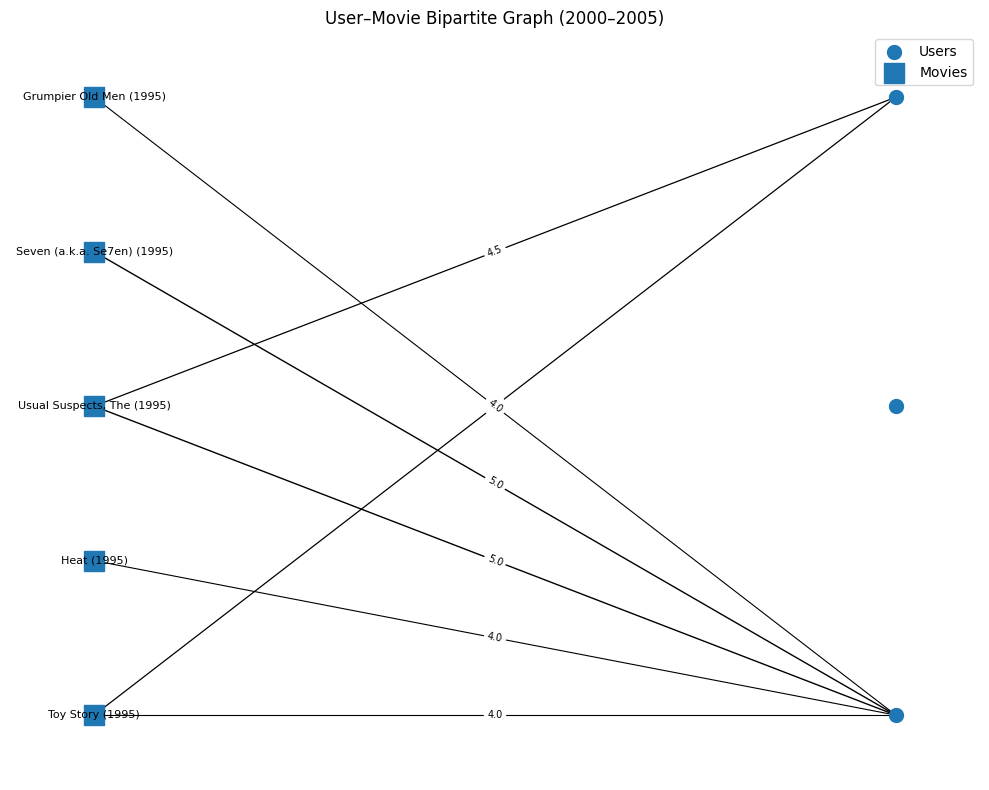

In [12]:
# Grafo 2000–2005
visualize_bipartite_graph(
    G_0005,
    max_users=3,
    max_movies=5,
    title="User–Movie Bipartite Graph (2000–2005)",
    show_edge_labels=True,
    edge_label_decimals=2,
    max_edges_labeled=50
)

### shell

bc sometimes this visualization its cleaner

In [13]:

def visualize_bipartite_shell(
    G,
    max_users=30,
    max_movies=30,
    title=None,
    show_edge_labels=True,
    edge_label_decimals=2,
    max_edges_labeled=50
):
    """
    Visualize a bipartite user–movie graph using a shell (circular) layout.

    Users and movies are placed on two concentric circles:
    - inner circle: movies
    - outer circle: users

    Parameters
    ----------
    G : networkx.Graph
        Bipartite graph with node attribute 'bipartite' = 'users' or 'movies'.
        Edges are expected to have a 'weight' attribute (e.g., rating).
    max_users : int
        Maximum number of user nodes to display.
    max_movies : int
        Maximum number of movie nodes to display.
    title : str or None
        Optional plot title.
    show_edge_labels : bool
        If True, display weight labels on some edges.
    edge_label_decimals : int
        Number of decimals for edge weight labels.
    max_edges_labeled : int
        Maximum number of edges to label (to avoid clutter).
    """

    # --- 1. Separate partitions ---
    user_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") == "users"]
    movie_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") == "movies"]

    if not user_nodes or not movie_nodes:
        print("Graph does not seem to have 'users' and 'movies' partitions properly set.")
        return

    # --- 2. Limit nodes: keep the most connected ones ---
    user_nodes_sorted = sorted(user_nodes, key=lambda n: G.degree(n), reverse=True)
    movie_nodes_sorted = sorted(movie_nodes, key=lambda n: G.degree(n), reverse=True)

    user_nodes_sorted = user_nodes
    movie_nodes_sorted = movie_nodes

    user_nodes_sub = user_nodes_sorted[:max_users]
    movie_nodes_sub = movie_nodes_sorted[:max_movies]

    nodes_to_keep = list(user_nodes_sub) + list(movie_nodes_sub)
    H = G.subgraph(nodes_to_keep).copy()

    # Update partitions for the subgraph
    users_H = [n for n, d in H.nodes(data=True) if d.get("bipartite") == "users"]
    movies_H = [n for n, d in H.nodes(data=True) if d.get("bipartite") == "movies"]

    # --- 3. Shell layout: inner shell = movies, outer shell = users ---
    # shell_layout places each list (shell) on a concentric circle
    pos = nx.shell_layout(H, nlist=[movies_H, users_H])

    # --- 4. Edge widths from weights ---
    edge_weights = [H[u][v].get("weight", 1.0) for u, v in H.edges()]
    edge_widths = [w * 0.2 for w in edge_weights]

    # --- 5. Draw nodes and edges ---
    plt.figure(figsize=(10, 10))

    # Movies (inner circle)
    nx.draw_networkx_nodes(
        H,
        pos,
        nodelist=movies_H,
        node_size=200,
        node_shape="s",
        label="Movies"
    )

    # Users (outer circle)
    nx.draw_networkx_nodes(
        H,
        pos,
        nodelist=users_H,
        node_size=100,
        node_shape="o",
        label="Users"
    )

    # Edges
    nx.draw_networkx_edges(
        H,
        pos,
        width=edge_widths
    )

    # --- 6. Labels for movies (titles) ---
    movie_labels = {n: H.nodes[n].get("title", n) for n in movies_H}
    nx.draw_networkx_labels(
        H,
        pos,
        labels=movie_labels,
        font_size=7
    )

    # (Usually we skip user labels to keep the plot readable,
    # but you can add them if you really want.)
    # user_labels = {n: n for n in users_H}
    # nx.draw_networkx_labels(H, pos, labels=user_labels, font_size=6)

    # --- 7. Edge labels (weights) ---
    if show_edge_labels:
        # Choose which edges to label (highest weights first if too many)
        edges = list(H.edges(data=True))
        if len(edges) > max_edges_labeled:
            edges_sorted = sorted(
                edges,
                key=lambda x: x[2].get("weight", 1.0),
                reverse=True
            )
            edges = edges_sorted[:max_edges_labeled]

        edge_labels = {
            (u, v): round(d.get("weight", 1.0), edge_label_decimals)
            for (u, v, d) in edges
        }

        nx.draw_networkx_edge_labels(
            H,
            pos,
            edge_labels=edge_labels,
            font_size=7
        )

    # --- 8. Final touches ---
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

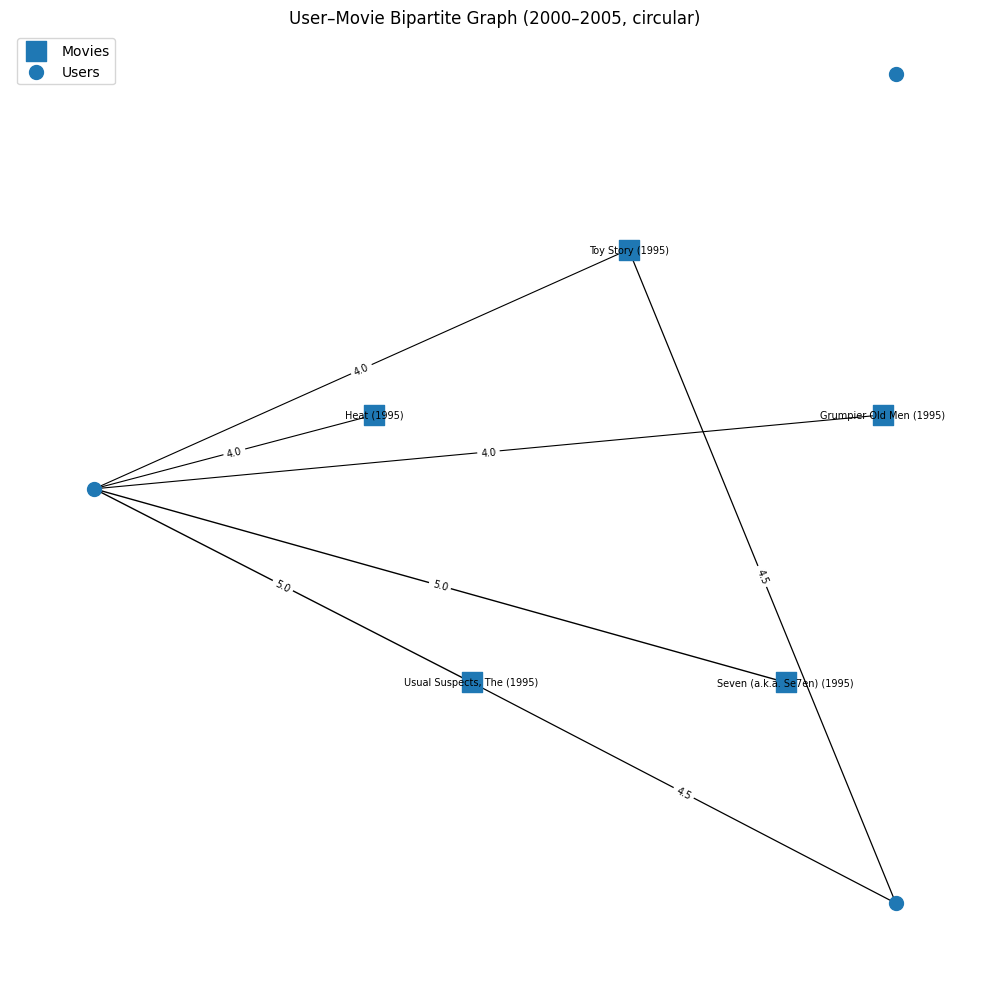

In [14]:
visualize_bipartite_shell(
    G_0005,
    max_users=3,
    max_movies=5,
    title="User–Movie Bipartite Graph (2000–2005, circular)"
)